# Figures for comparison of arrival direction and joint models

Here use the output from the `arrival_vs_joint` notebook to plot the figures shown in the paper.
<br>
<br>
*This code is used to produce Figures 6, 7 and 8 (left panel) in Capel & Mortlock (2019).* 

In [1]:
import numpy as np
import h5py
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame

from fancy import Data, Results
from fancy.plotting import AllSkyMap, Corner
from fancy.plotting.colours import *

# to match paper style
plt.style.use('minimalist') 

In [2]:
# Define output files
source_type = "SBG_23"
detector_type = "TA"

exp_factor = 5.

sim_output_file = '../output/joint_model_simulation_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)
arrival_output_file = '../output/arrival_direction_fit_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)
joint_output_file = '../output/joint_fit_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)

In [ ]:
'''set detector and detector properties'''
if detector_type == "TA":
    from fancy.detector.TA2015 import detector_params, Eth
elif detector_type == "PAO":
    from fancy.detector.auger2014 import detector_params, Eth
else:
    raise Exception("Undefined detector type!")

## Figure 6

The simulated data set and the Auger exposure.

In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u

from fancy.detector.exposure import m_dec
from fancy.interfaces.stan import Direction

# modify exposure contained in detector_params
# detector_params[3] == alpha_T
detector_params[3] *= exp_factor

In [4]:
# Read in simulation data
with h5py.File(sim_output_file, 'r') as f:
    uhecr = f['uhecr']
    arrival_direction = Direction(uhecr['unit_vector'][()])
    energy = uhecr['energy'][()]
    
    source = f['source']
    source_direction = Direction(source['unit_vector'][()])  

In [5]:
# Calculate the exposure as a function of declination
num_points = 220
rightascensions = np.linspace(-180, 180, num_points)
declinations = np.linspace(-np.pi/2, np.pi/2, num_points)

m = np.asarray([m_dec(d, detector_params) for d in declinations])
exposure_factor = (m / np.max(m))

In [6]:
# reset exposure factor
detector_params[3] /= exp_factor

In [8]:
# Colourmaps and normalisation
# Exposure
exp_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', 
                                                        [lightgrey, grey], N = 6)
norm_proj = mpl.colors.Normalize(exposure_factor.min(), exposure_factor.max())

# UHECR energy
# max. of energy bin, set s.t. values in 
# max(np.digitize(energy, energy_bins) - 1) < len(uhecr_color)
Emax = np.ceil(np.max(energy) / 10.) * 10.  


uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(Eth), np.log(Emax), 4, base = np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)

# Legend
legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color = 'w', 
                                    label = 'sources', markersize = 10, 
                                    markerfacecolor = 'k'), 
                   mpl.lines.Line2D([0], [0], marker='o', color='w', 
                                    label='UHECRs', markersize = 15, 
                                    markerfacecolor = midblue, alpha = 0.8)]

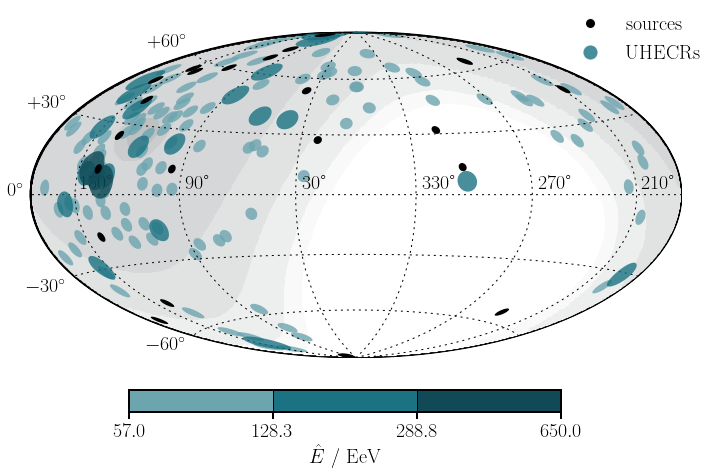

In [9]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);

# Sources
for lon, lat in np.nditer([source_direction.lons, source_direction.lats]):
    skymap.tissot(lon, lat, 2.0, 30, facecolor = 'k', alpha = 1.0, zorder = 5)
    
# UHECRs
for lon, lat, E in np.nditer([arrival_direction.lons, arrival_direction.lats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(lon, lat, 3.0 + (i*2), 30, 
                  facecolor = uhecr_cmap.colors[i], alpha = 0.8, zorder = i+2)
    
# Exposure
# Uses scatter as bug with AllSkyMap.pcolormesh and contour that I still need to fix...
for dec, proj in np.nditer([declinations, exposure_factor]):
    decs = np.tile(dec, num_points)
    c = SkyCoord(ra = rightascensions * u.rad,
                 dec = decs * u.rad, frame = 'icrs')
    lon = c.galactic.l.deg
    lat = c.galactic.b.deg
    if (proj == 0):
        skymap.scatter(lon, lat, latlon = True, linewidth = 3,
                       color = white, alpha = 1, zorder = 1)
    else:
        skymap.scatter(lon, lat, latlon = True, linewidth = 3,
                       color = exp_cmap(norm_proj(proj)), alpha = 1, zorder = 1)
        
# Annotation
skymap.draw_border()
skymap.draw_standard_labels(minimal = True, fontsize = 20)
ax.legend(handles = legend_elements, bbox_to_anchor = (0.8, 0.85), fontsize = 20)

# Colorbar
cb_ax = plt.axes([0.25, 0, .5, .05], frameon = False)
bar = mpl.colorbar.ColorbarBase(cb_ax, norm = uhecr_norm, cmap = uhecr_cmap,
                                orientation = 'horizontal', drawedges = True, 
                                alpha = 1)
bar.set_label('$\hat{E}$ / EeV', color = 'k', fontsize = 20)
bar.ax.tick_params(labelsize = 20) 

## Figure 7

Comparison of the joint and arrival direction fits.

In [11]:
# Get f samples for both models and true f value.
f_a = Results(arrival_output_file).get_chain(['f'])['f']
f_j = Results(joint_output_file).get_chain(['f'])['f']
f_true = Results(sim_output_file).get_truths(['f'])['f']

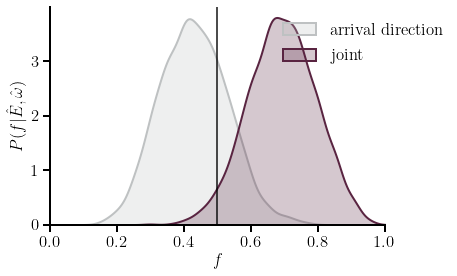

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 4))

sns.distplot(f_a, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 0}, 
             color = grey, label = 'arrival direction')
sns.distplot(f_j, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 1}, 
             color = purple, label = 'joint')
ax.axvline(f_true, 0, 10, color = 'k', zorder = 3, lw = 2., alpha = 0.7)

ax.set_xlim(0, 1)
# ax.set_ylim(0, 10)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f | \hat{E}, \hat{\omega})$')
ax.legend(bbox_to_anchor = (0.65, 1.0));

## Figure 8 (left panel)

In [13]:
# Get chains from joint fit and truths from simulation
results_sim = Results(sim_output_file)
results_fit = Results(joint_output_file)

keys = ['F0', 'L', 'alpha', 'B', 'f']
chain = results_fit.get_chain(keys)

# Convert form Stan units to plot units
chain['F0'] = chain['F0'] / 1.0e3 # km^-2 yr^-1
chain['L'] = chain['L'] * 10 # 10^-38 yr^-1

truth_keys = ['F0', 'L', 'alpha', 'B', 'f']
truth = results_sim.get_truths(truth_keys)
info_keys = ['Eth', 'Eth_sim']
info = results_sim.get_truths(info_keys)

# Correct for different Eth in sim and fit
# Also scale to plot units
flux_scale = (info['Eth'] / info['Eth_sim'])**(1 - truth['alpha'])
truth['F0'] = truth['F0'] * flux_scale # km^-2 yr^-1
truth['L'] = truth['L'][0] * flux_scale / 1.0e39 * 10 # 10^-38 yr^-1

In [14]:
labels = {}
labels['L'] = r'$L$ / $10^{38}$ $\mathrm{yr}^{-1}$'
labels['F0'] = r'$F_0$ / $\mathrm{km}^{-2} \ \mathrm{yr}^{-1}$'
labels['B'] = r'$B$ / $\mathrm{nG}$'
labels['alpha'] = r'$\alpha$'
labels['f'] = r'$f$' 

In [15]:
params = np.column_stack([chain[key] for key in keys])
truths = [truth[key] for key in keys]

# Make nicely labelled dict
chain_for_df = {}
for key in keys:
    chain_for_df[labels[key]] = chain[key]

# Make ordered dataframe
df = DataFrame(data = chain_for_df)
df = df[[labels['F0'], labels['L'], labels['alpha'], labels['B'], labels['f']]]

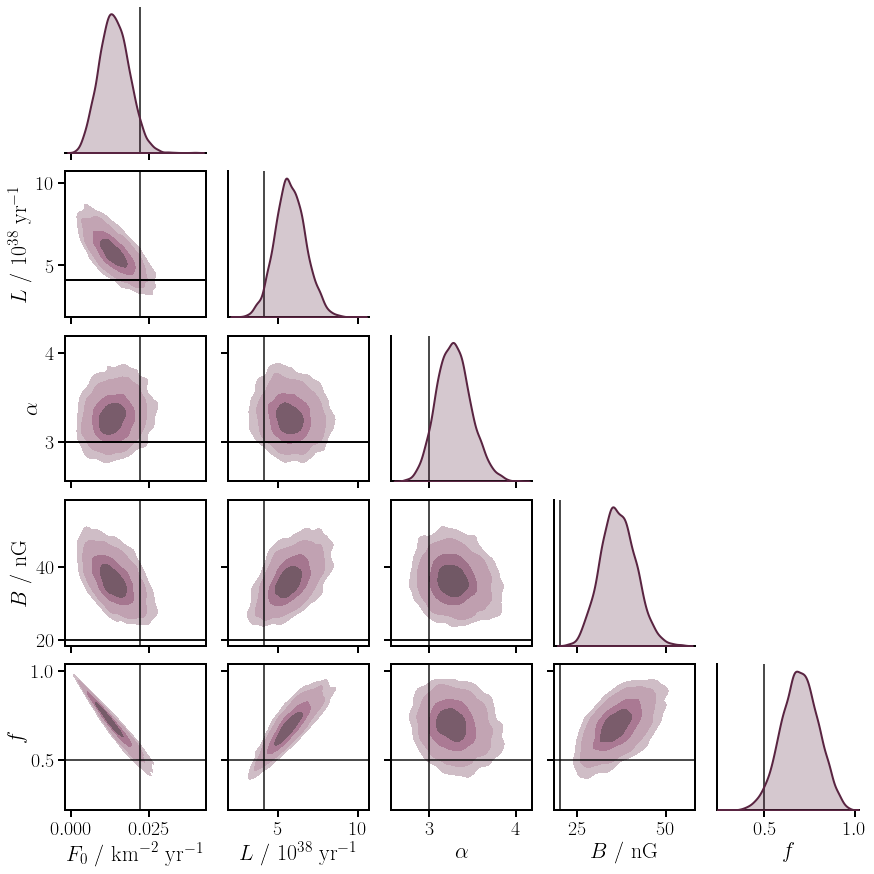

In [16]:
corner = Corner(df, truths, color=purple, contour_color=purple_contour) 

### Footnote

In the paper I made a small typo in the plot labelling, $F_0$ is indeed in units of $\rm{km}^{-2} \ yr^{-1}$. Also, there are some small differences in the fit posteriors due to the use of a random seed. 